In [21]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eigvalsh, eigh, norm

# Plot/table defaults for interactive inspection.
plt.rcParams["figure.dpi"] = 130
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 80)

# Project folders (kept consistent with the other thesis notebooks).
PROJECT_ROOT = Path(r"C:\Users\bseis\ABthesis").resolve()
DATA_ROOT = PROJECT_ROOT / "data"
ANALYSIS = DATA_ROOT / "analysis"

# Output location from the MI training-window robustness notebook.
MI_ROBUST_DIR = ANALYSIS / "mi_training_window_robustness"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT   :", DATA_ROOT)
print("ANALYSIS    :", ANALYSIS)
print("MI_ROBUST_DIR exists?", MI_ROBUST_DIR.exists())

# Kernel stabilization targets (same as weekly_computation).
RIDGE_MIN_EIG = 1e-6
KAPPA_MAX = 1e8

# File-naming knobs (must match how the robustness artifacts were saved).
K_NEIGH = 6
MIN_OVERLAP = 156
NORM_TAG = "sqrt"

# Train-start dates used in the robustness run.
train_start_grid = [
    pd.Timestamp("1997-01-03"),
    pd.Timestamp("2000-01-07"),
    pd.Timestamp("2002-01-04"),
    pd.Timestamp("2004-01-02"),
    pd.Timestamp("2006-01-06"),
    pd.Timestamp("2008-01-04"),
    pd.Timestamp("2010-01-01"),
    pd.Timestamp("2012-01-06"),
    pd.Timestamp("2014-01-03"),
]

print("Train-start grid:")
for t0 in train_start_grid:
    print(" ", t0.date())

PROJECT_ROOT: C:\Users\bseis\ABthesis
DATA_ROOT   : C:\Users\bseis\ABthesis\data
ANALYSIS    : C:\Users\bseis\ABthesis\data\analysis
MI_ROBUST_DIR exists? True
Train-start grid:
  1997-01-03
  2000-01-07
  2002-01-04
  2004-01-02
  2006-01-06
  2008-01-04
  2010-01-01
  2012-01-06
  2014-01-03


In [22]:
# Kernel sanitization, PSD projection, ridge choice, distances

def _ensure_df_square(df: pd.DataFrame, name: str = "M") -> pd.DataFrame:
    """
    Ensure a DataFrame is square with matching index/columns.
    (Copied from weekly_computation.)
    """
    assert isinstance(df, pd.DataFrame), f"{name} must be a DataFrame"
    if not df.index.equals(df.columns):
        common = df.index.intersection(df.columns)
        df = df.loc[common, common].copy()
    return df


def sanitize_kernel(df: pd.DataFrame, *, assume_nmi: bool) -> pd.DataFrame:
    """
    Finite, symmetric kernel with 0 diagonal.

    - If assume_nmi: clip to [0,1].
    - Else (MI bits): floor negatives to 0 (KSG noise), keep upper tail.

    This is copied from weekly_computation (Chunk 1).
    """
    df = _ensure_df_square(df, "Kernel")
    A = df.to_numpy(dtype="float64", copy=True)

    bad = ~np.isfinite(A)
    if bad.any():
        print(f"[sanitize] non-finite → 0 (count={int(bad.sum())})")
        A[bad] = 0.0

    if assume_nmi:
        A = np.clip(A, 0.0, 1.0)
    else:
        # MI (bits): ≥ 0 in theory; floor tiny negatives
        A = np.maximum(A, 0.0)

    A = 0.5 * (A + A.T)
    np.fill_diagonal(A, 0.0)

    sym_err = float(np.max(np.abs(A - A.T)))
    print(
        f"[sanitize] sym_err={sym_err:.2e} | diag set to 0 | "
        f"min={A.min():.4e} | max={A.max():.4e}"
    )

    return pd.DataFrame(A, index=df.index, columns=df.columns)


def nearest_psd(A: np.ndarray, eps_eig: float = 0.0) -> np.ndarray:
    """
    Higham-style nearest PSD: clip eigenvalues at eps_eig.

    Copied from weekly_computation (Chunk 1).
    """
    A = 0.5 * (A + A.T)
    w, V = eigh(A)
    w = np.maximum(w, eps_eig)
    B = (V * w) @ V.T
    return 0.5 * (B + B.T)


def choose_ridge(
    Qpsd: np.ndarray,
    target_min: float,
    kappa_max: float,
    max_steps: int = 12,
) -> float:
    """
    Adaptive ridge selection: smallest ridge on a log10 grid such that
    min eigenvalue ≥ target_min and cond(Qpsd + λI) ≤ kappa_max.

    Copied from weekly_computation (Chunk 1).
    """
    w = eigvalsh(Qpsd)
    if (w[0] >= target_min) and (w[-1] / max(w[0], 1e-16) <= kappa_max):
        return 0.0

    ridge = 1e-8
    for _ in range(max_steps):
        w2 = eigvalsh(Qpsd + ridge * np.eye(Qpsd.shape[0]))
        if (w2[0] >= target_min) and (w2[-1] / w2[0] <= kappa_max):
            return float(ridge)
        ridge *= 10.0

    return float(ridge)


def vec_offdiag(A: np.ndarray) -> np.ndarray:
    """Vectorize the strict upper-triangular part (off-diagonals) of A."""
    n = A.shape[0]
    mask = ~np.eye(n, dtype=bool)
    return A[mask]


def kernel_distance_metrics(A: np.ndarray, B: np.ndarray) -> dict:
    """
    Distance / similarity metrics between two kernels A and B:

    - frob:      ||B - A||_F
    - frob_rel:  ||B - A||_F / ||A||_F
    - frob_off:  Frobenius norm on off-diagonal entries only
    - frob_off_rel: same, normalized by ||A_off||_F
    - max_off:   max absolute off-diagonal difference
    - corr_off:  Pearson correlation of off-diagonal entries
    """
    A = np.asarray(A, dtype="float64")
    B = np.asarray(B, dtype="float64")
    assert A.shape == B.shape

    D = B - A

    frob = float(norm(D, "fro"))
    frob_rel = frob / max(float(norm(A, "fro")), 1e-12)

    a_off = vec_offdiag(A)
    b_off = vec_offdiag(B)
    d_off = b_off - a_off

    frob_off = float(norm(d_off))
    frob_off_rel = frob_off / max(float(norm(a_off)), 1e-12)
    max_off = float(np.max(np.abs(d_off))) if d_off.size else 0.0

    if (np.std(a_off) > 0) and (np.std(b_off) > 0):
        corr_off = float(np.corrcoef(a_off, b_off)[0, 1])
    else:
        corr_off = np.nan

    return dict(
        frob=frob,
        frob_rel=frob_rel,
        frob_off=frob_off,
        frob_off_rel=frob_off_rel,
        max_off=max_off,
        corr_off=corr_off,
    )


def plot_distance_heatmap(mat: np.ndarray, labels, title: str, cmap="viridis"):
    """
    Simple imshow heatmap for a distance/similarity matrix.
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(mat, cmap=cmap)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("value")
    plt.tight_layout()
    plt.show()

In [23]:
# Load raw NMI kernels

nmi_raw: dict[pd.Timestamp, pd.DataFrame] = {}
Q_est: dict[pd.Timestamp, pd.DataFrame] = {}
Q_psd: dict[pd.Timestamp, np.ndarray] = {}
Q_reg: dict[pd.Timestamp, pd.DataFrame] = {}
ridge_used: dict[pd.Timestamp, float] = {}
evals_reg: dict[pd.Timestamp, np.ndarray] = {}

print("Loading raw NMI kernels and constructing stabilized Q_reg…")

for t0 in train_start_grid:
    tag = t0.strftime("%Y%m%d")
    nmi_path = MI_ROBUST_DIR / f"nmi_bits_trainstart_{tag}_k{K_NEIGH}_min{MIN_OVERLAP}_{NORM_TAG}.parquet"

    print("\n" + "=" * 80)
    print(f"[{t0.date()}] loading:", nmi_path)
    R_named = pd.read_parquet(nmi_path)
    print(f"  raw NMI shape: {R_named.shape}")

    nmi_raw[t0] = R_named

    # 1) Sanitize (NMI semantics → clip[0,1], 0 diagonal, symmetric)
    Q_df = sanitize_kernel(R_named, assume_nmi=True)
    Q_est[t0] = Q_df
    labels = list(Q_df.index)
    n = len(labels)
    print(f"  [Q_est] labels={n}")

    # 2) PSD projection (nearest PSD)
    Q_psd_arr = nearest_psd(Q_df.to_numpy(copy=True), eps_eig=0.0)
    Q_psd[t0] = Q_psd_arr

    # 3) Adaptive ridge (Experiment‑3 / weekly_computation logic)
    ridge = choose_ridge(Q_psd_arr, target_min=RIDGE_MIN_EIG, kappa_max=KAPPA_MAX)
    ridge_used[t0] = ridge

    Q_reg_arr = Q_psd_arr + ridge * np.eye(n)
    Q_reg_arr = 0.5 * (Q_reg_arr + Q_reg_arr.T)
    Q_reg_df = pd.DataFrame(Q_reg_arr, index=labels, columns=labels)
    Q_reg[t0] = Q_reg_df

    w = eigvalsh(Q_reg_arr)
    evals_reg[t0] = w

    print(
        f"  [Q_reg] ridge={ridge:.1e} | eig_min={w.min():.3e} | "
        f"eig_max={w.max():.3e} | cond≈{w.max()/max(w.min(),1e-16):.2e}"
    )

# Sanity check: all kernels share the same label set
label_sets = {t0: tuple(Q_est[t0].index) for t0 in train_start_grid}
all_equal = all(label_sets[t0] == label_sets[train_start_grid[0]] for t0 in train_start_grid)
print("\nAll label sets identical across training windows?", all_equal)

Loading raw NMI kernels and constructing stabilized Q_reg…

[1997-01-03] loading: C:\Users\bseis\ABthesis\data\analysis\mi_training_window_robustness\nmi_bits_trainstart_19970103_k6_min156_sqrt.parquet
  raw NMI shape: (1000, 1000)
[sanitize] non-finite → 0 (count=93648)
[sanitize] sym_err=0.00e+00 | diag set to 0 | min=0.0000e+00 | max=6.6534e-01
  [Q_est] labels=1000
  [Q_reg] ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=5.110e+01 | cond≈5.11e+06

[2000-01-07] loading: C:\Users\bseis\ABthesis\data\analysis\mi_training_window_robustness\nmi_bits_trainstart_20000107_k6_min156_sqrt.parquet
  raw NMI shape: (1000, 1000)
[sanitize] non-finite → 0 (count=93648)
[sanitize] sym_err=0.00e+00 | diag set to 0 | min=0.0000e+00 | max=6.6534e-01
  [Q_est] labels=1000
  [Q_reg] ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=5.387e+01 | cond≈5.39e+06

[2002-01-04] loading: C:\Users\bseis\ABthesis\data\analysis\mi_training_window_robustness\nmi_bits_trainstart_20020104_k6_min156_sqrt.parquet
  raw NMI sh

In [27]:
# distance between estimation kernel and stabilized Q_reg for each start date

rows_self: list[dict] = []

for t0 in train_start_grid:
    # sanitized estimation kernel
    A = Q_est[t0].to_numpy(dtype="float64")
    # PSD + ridge
    B = Q_reg[t0].to_numpy(dtype="float64")

    met = kernel_distance_metrics(A, B)
    met.update(
        train_start=t0,
        ridge=ridge_used[t0],
        eig_min=float(evals_reg[t0].min()),
        eig_max=float(evals_reg[t0].max()),
    )
    rows_self.append(met)

df_self = (
    pd.DataFrame(rows_self)
    .set_index("train_start")
    .sort_index()
)

print("Distance between Q_est (sanitized) and Q_reg (PSD+ridge) for each training start:")
display(df_self)

Distance between Q_est (sanitized) and Q_reg (PSD+ridge) for each training start:


,frob,frob_rel,frob_off,frob_off_rel,max_off,corr_off,ridge,eig_min,eig_max
train_start,,,,,,,,,
1997-01-03,14.024959,0.246552,10.797128,0.189808,0.313969,0.960483,0.00001,0.00001,51.098278
2000-01-07,13.968629,0.234093,10.576932,0.177253,0.313198,0.965693,0.00001,0.00001,53.867266
2002-01-04,13.998352,0.222164,10.490432,0.166491,0.313722,0.969784,0.00001,0.00001,57.424465
2004-01-02,14.267398,0.213904,10.612830,0.159113,0.312957,0.972448,0.00001,0.00001,61.099338
2006-01-06,14.754577,0.206343,10.906122,0.152522,0.313027,0.974997,0.00001,0.00001,65.824516
2008-01-04,15.509679,0.199199,11.400731,0.146425,0.313340,0.977258,0.00001,0.00001,72.084369
2010-01-01,15.148993,0.217764,11.208306,0.161117,0.312089,0.973558,0.00001,0.00001,63.422498
2012-01-06,15.239309,0.257178,11.329574,0.191197,0.305303,0.966922,0.00001,0.00001,51.536737
2014-01-03,16.701934,0.266586,12.335697,0.196895,0.299563,0.967050,0.00001,0.00001,53.301627


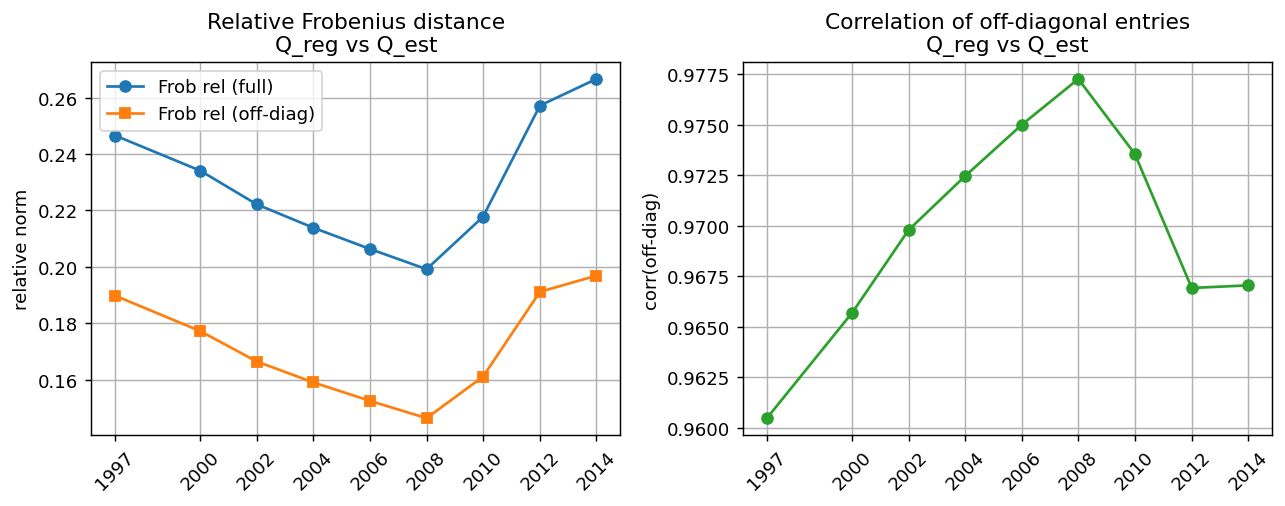

In [28]:
# Visualize self-distance metrics over training start dates

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Frobenius
ax = axes[0]
ax.plot(df_self.index, df_self["frob_rel"], marker="o", label="Frob rel (full)")
ax.plot(df_self.index, df_self["frob_off_rel"], marker="s", label="Frob rel (off‑diag)")
ax.set_title("Relative Frobenius distance\nQ_reg vs Q_est")
ax.set_ylabel("relative norm")
ax.legend()
ax.grid(True)

# Correlation of off-diagonals
ax = axes[1]
ax.plot(df_self.index, df_self["corr_off"], marker="o", color="tab:green")
ax.set_title("Correlation of off-diagonal entries\nQ_reg vs Q_est")
ax.set_ylabel("corr(off-diag)")
ax.grid(True)

for ax in axes:
    ax.set_xticks(df_self.index)
    ax.set_xticklabels([d.strftime("%Y") for d in df_self.index], rotation=45)

plt.tight_layout()
plt.show()

Diagonal shifts from Q_est → Q_reg (mostly from ridge):


,diag_delta_min,diag_delta_max,diag_delta_mean
train_start,,,
1997-01-03,0.00001,0.726887,0.269150
2000-01-07,0.00001,0.702822,0.274545
2002-01-04,0.00001,0.684098,0.278669
2004-01-02,0.00001,0.668869,0.286713
2006-01-06,0.00001,0.651973,0.298670
2008-01-04,0.00001,0.699007,0.315828
2010-01-01,0.00001,0.702801,0.307544
2012-01-06,0.00001,0.575940,0.307534
2014-01-03,0.00001,0.655105,0.339173


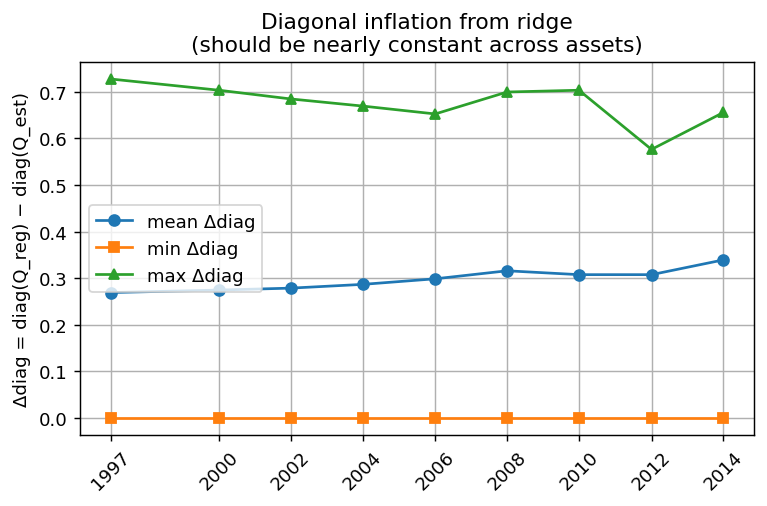

In [29]:
# How much does ridge inflate the diagonal?

rows_diag: list[dict] = []

for t0 in train_start_grid:
    A0 = Q_est[t0].to_numpy(dtype="float64")
    B = Q_reg[t0].to_numpy(dtype="float64")
    diag_delta = np.diag(B - A0)

    rows_diag.append(
        dict(
            train_start=t0,
            diag_delta_min=float(diag_delta.min()),
            diag_delta_max=float(diag_delta.max()),
            diag_delta_mean=float(diag_delta.mean()),
        )
    )

df_diag = (
    pd.DataFrame(rows_diag)
    .set_index("train_start")
    .sort_index()
)

print("Diagonal shifts from Q_est → Q_reg (mostly from ridge):")
display(df_diag)

plt.figure(figsize=(6, 4))
plt.plot(df_diag.index, df_diag["diag_delta_mean"], marker="o", label="mean Δdiag")
plt.plot(df_diag.index, df_diag["diag_delta_min"], marker="s", label="min Δdiag")
plt.plot(df_diag.index, df_diag["diag_delta_max"], marker="^", label="max Δdiag")
plt.xticks(df_diag.index, [d.strftime("%Y") for d in df_diag.index], rotation=45)
plt.ylabel("Δdiag = diag(Q_reg) − diag(Q_est)")
plt.title("Diagonal inflation from ridge\n(should be nearly constant across assets)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

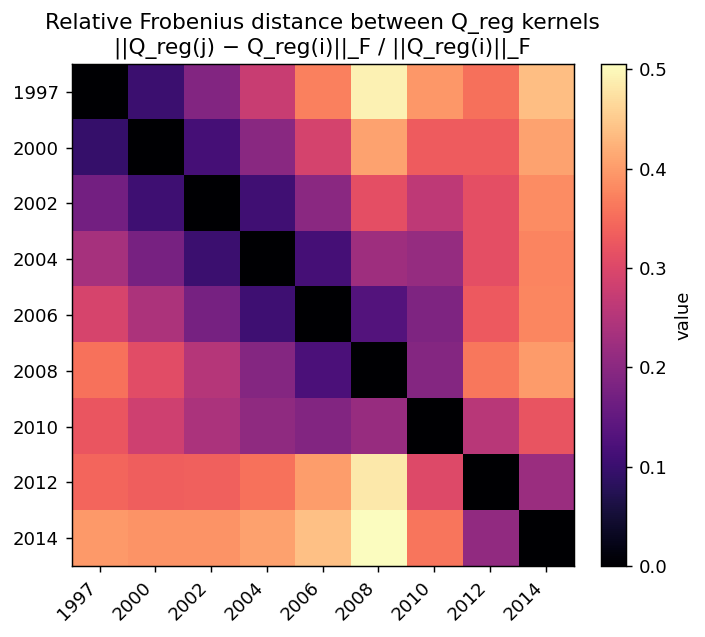

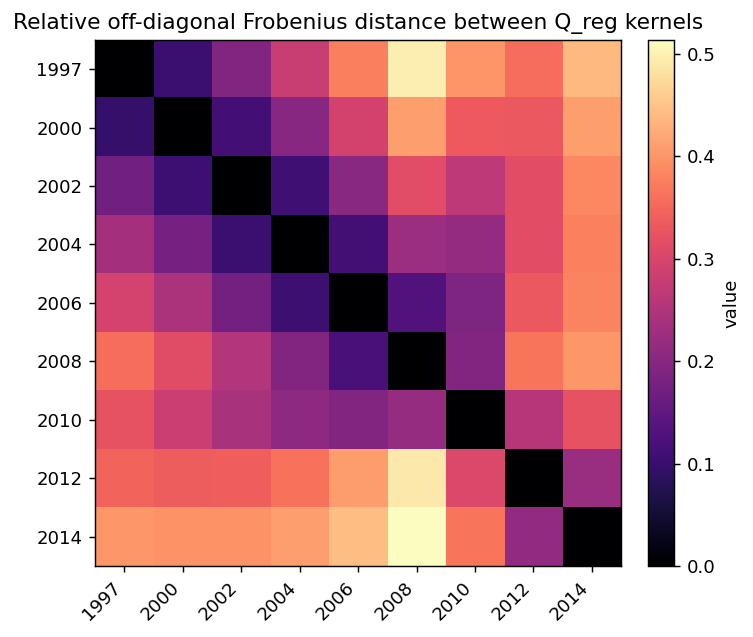

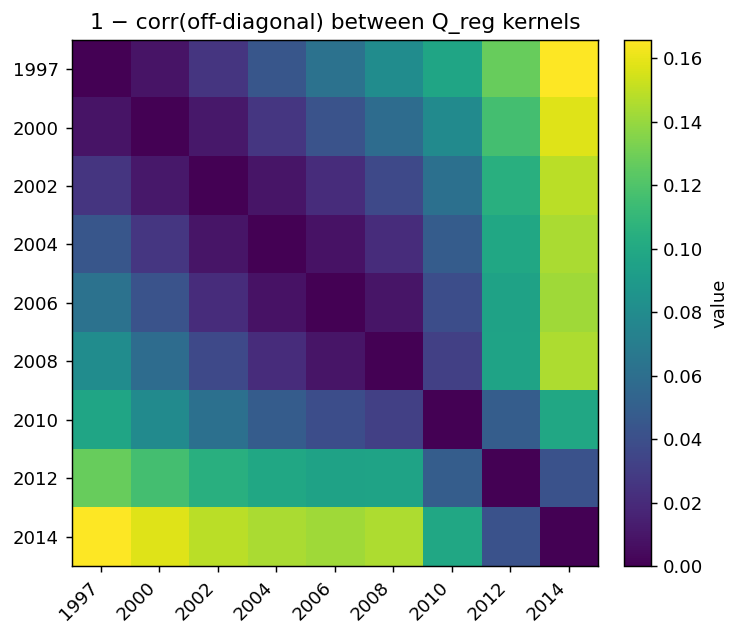

In [31]:
# Pairwise distances among stabilized Q_reg kernels

n_grid = len(train_start_grid)
labels_year = [t0.strftime("%Y") for t0 in train_start_grid]

frob_rel_mat = np.zeros((n_grid, n_grid), dtype="float64")
frob_off_rel_mat = np.zeros_like(frob_rel_mat)
corr_off_mat = np.zeros_like(frob_rel_mat)

for i, t_i in enumerate(train_start_grid):
    A = Q_reg[t_i].to_numpy(dtype="float64")
    for j, t_j in enumerate(train_start_grid):
        B = Q_reg[t_j].to_numpy(dtype="float64")
        met = kernel_distance_metrics(A, B)
        frob_rel_mat[i, j] = met["frob_rel"]
        frob_off_rel_mat[i, j] = met["frob_off_rel"]
        corr_off_mat[i, j] = met["corr_off"]

# Heatmap: relative Frobenius distance
plot_distance_heatmap(
    frob_rel_mat,
    labels_year,
    title="Relative Frobenius distance between Q_reg kernels\n||Q_reg(j) − Q_reg(i)||_F / ||Q_reg(i)||_F",
    cmap="magma",
)

# Heatmap: relative off-diagonal Frobenius distance
plot_distance_heatmap(
    frob_off_rel_mat,
    labels_year,
    title="Relative off-diagonal Frobenius distance between Q_reg kernels",
    cmap="magma",
)

# Heatmap: 1 − corr(off-diagonal)
one_minus_corr = 1.0 - corr_off_mat
plot_distance_heatmap(
    one_minus_corr,
    labels_year,
    title="1 − corr(off-diagonal) between Q_reg kernels",
    cmap="viridis",
)

In [33]:
# Summary stats

rows_pair: list[dict] = []

for i, t_i in enumerate(train_start_grid):
    A = Q_reg[t_i].to_numpy(dtype="float64")
    for j, t_j in enumerate(train_start_grid):
        if j <= i:
            continue
        B = Q_reg[t_j].to_numpy(dtype="float64")
        met = kernel_distance_metrics(A, B)
        rows_pair.append(
            dict(
                train_start_i=t_i,
                train_start_j=t_j,
                frob_rel=met["frob_rel"],
                frob_off_rel=met["frob_off_rel"],
                max_off=met["max_off"],
                corr_off=met["corr_off"],
            )
        )

df_pairs = (
    pd.DataFrame(rows_pair)
    .sort_values(["train_start_i", "train_start_j"])
    .reset_index(drop=True)
)

print("Pairwise distances among Q_reg kernels (upper triangle):")
display(df_pairs)

Pairwise distances among Q_reg kernels (upper triangle):


,train_start_i,train_start_j,frob_rel,frob_off_rel,max_off,corr_off
0,1997-01-03,2000-01-07,0.101699,0.102757,0.062671,0.991039
1,1997-01-03,2002-01-04,0.190458,0.192517,0.112568,0.974477
2,1997-01-03,2004-01-02,0.276052,0.279002,0.150827,0.955533
3,1997-01-03,2006-01-06,0.372742,0.376624,0.197478,0.937229
4,1997-01-03,2008-01-04,0.492262,0.497256,0.219654,0.919325
5,1997-01-03,2010-01-01,0.396532,0.400187,0.227266,0.902408
6,1997-01-03,2012-01-06,0.355147,0.357952,0.278910,0.873038
7,1997-01-03,2014-01-03,0.436299,0.438645,0.364331,0.834267
8,2000-01-07,2002-01-04,0.112817,0.114004,0.067884,0.989304
9,2000-01-07,2004-01-02,0.198593,0.200605,0.110768,0.973724
